In [1]:
from statsmodels.stats.power import TTestIndPower

# Parameters for power analysis
alpha = 0.1       # Type I error rate (significance level)
power = 0.8       # Statistical power (probability of detecting a true effect)
std_dev = 1.5     # Standard deviation of the metric (e.g., revenue per user)
effect_diff = 0.88 - 0.80 # Expected difference in means (e.g., ARPU difference between groups)

# Calculate the effect size (Cohen's d)
# Cohen's d quantifies the standardized difference between two means.
# It's calculated as the difference between the means divided by the standard deviation.
effect_size = effect_diff / std_dev

# Perform sample size calculation
# TTestIndPower is used for power analysis of a two-sample independent t-test.
analysis = TTestIndPower()

# Solve for the required sample size per group
# 'alternative='two-sided'' specifies that we are looking for a difference in either direction (increase or decrease).
sample_size = analysis.solve_power(effect_size=effect_size,
                                   power=power,
                                   alpha=alpha,
                                   alternative='two-sided')

# Print the calculated minimum sample size, rounded down to the nearest integer
print(f"Required minimum sample size per group ≈ {int(sample_size)} users")

Required minimum sample size per group ≈ 4347 users


📊 Group Summary Statistics:
            user_id  converted   churned   revenue
test_group                                        
A              4347   0.095698  0.331493  0.074074
B              4347   0.151139  0.320451  0.136411

✅ Conversion Rate Summary:
            total_users  total_converted  conversion_rate
test_group                                               
A                  4347              416         9.569818
B                  4347              657        15.113872

📊 Welch's t-Test Results for ARPU:
T-statistic: -8.8170
P-value: 0.0000

📉 Z-Test Results for Churn Rate:
Z-statistic: 1.0983
P-value: 0.2721

🎯 95% Confidence Intervals for ARPU:
Group A: (0.06590672762295702, 0.0822414205251911)
Group B: (0.1252120969530879, 0.14761053934780924)

🧮 Cohen's d Effect Size: -0.1891


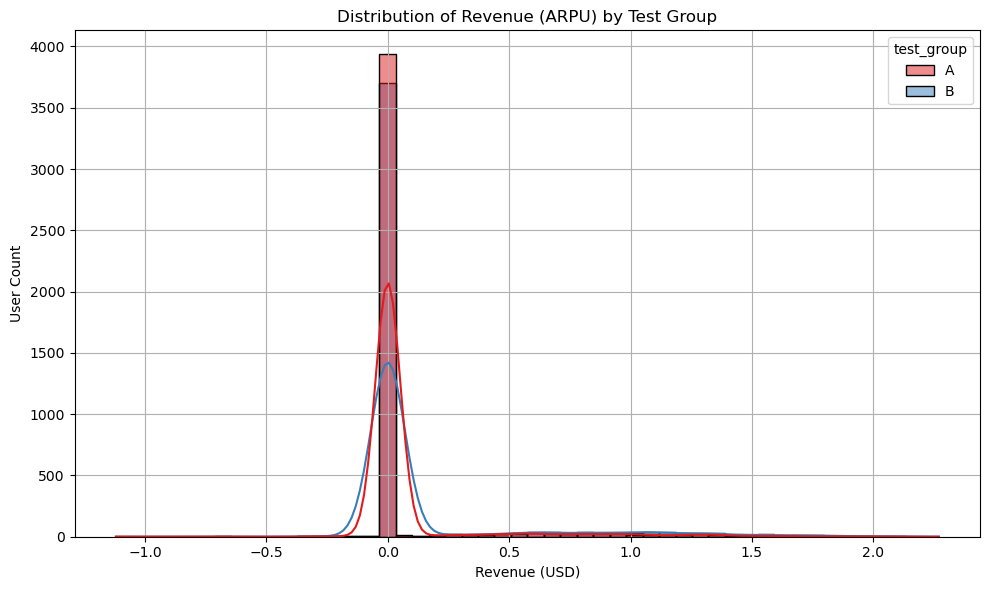

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_11188\2206847424.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="test_group", y="converted", data=conv_rates, palette="Set2")


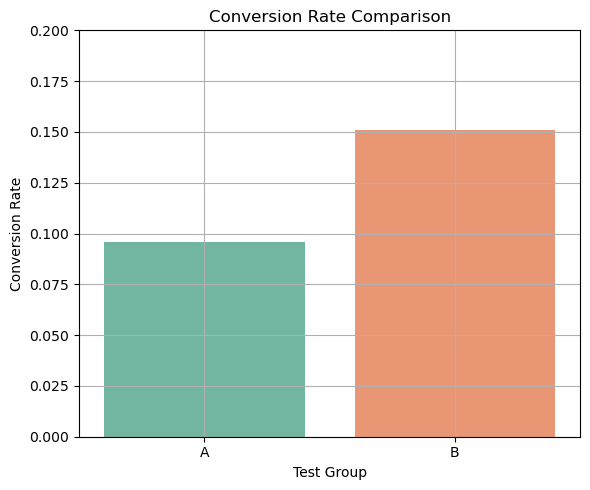

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_11188\2206847424.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='test_group', y='revenue', data=df_plot, palette=palette)


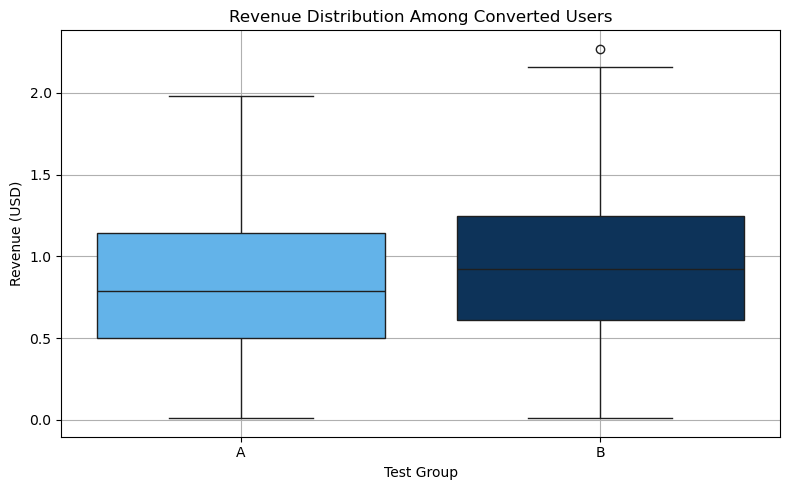

In [4]:
# 📦 Import necessary libraries
import pandas as pd
import numpy as np
import uuid
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm

# 🎲 Set random seed for reproducibility
np.random.seed(42)

# 📊 Define the number of users per group (control and variant)
n_per_group = 4347

# 📋 A/B test configuration for each group
params = {
    'A': {'conversion_rate': 0.10, 'churn_rate': 0.35, 'revenue_mean': 0.80},
    'B': {'conversion_rate': 0.15, 'churn_rate': 0.30, 'revenue_mean': 0.88}
}

# 🧪 Function to simulate user data for a given group
def simulate_group(group_name, n):
    p = params[group_name]
    user_ids = [str(uuid.uuid4()) for _ in range(n)]
    converted = np.random.binomial(1, p['conversion_rate'], n)
    churned = np.random.binomial(1, p['churn_rate'], n)
    
    # Revenue is only assigned to converted users
    revenue = np.where(
        converted == 1,
        np.round(np.random.normal(loc=p['revenue_mean'], scale=0.5, size=n), 2),
        0
    )

    return pd.DataFrame({
        'user_id': user_ids,
        'test_group': group_name,
        'converted': converted,
        'churned': churned,
        'revenue': revenue
    })

# 🧱 Simulate both groups
df_A = simulate_group('A', n_per_group)
df_B = simulate_group('B', n_per_group)

# 🔗 Combine A and B groups into a single DataFrame
df = pd.concat([df_A, df_B]).reset_index(drop=True)

# 📈 Basic group-level statistics
summary = df.groupby("test_group").agg({
    "user_id": "count",
    "converted": "mean",
    "churned": "mean",
    "revenue": "mean"
})
print("📊 Group Summary Statistics:")
print(summary)

# ✅ Conversion rate calculation
conversion_summary = df.groupby("test_group").agg(
    total_users=("user_id", "count"),
    total_converted=("converted", "sum")
)
conversion_summary["conversion_rate"] = (
    conversion_summary["total_converted"] / conversion_summary["total_users"] * 100
)
print("\n✅ Conversion Rate Summary:")
print(conversion_summary)

# 💵 Welch's t-test for ARPU comparison
arpu_A = df[df["test_group"] == "A"]["revenue"]
arpu_B = df[df["test_group"] == "B"]["revenue"]
t_stat, p_value = ttest_ind(arpu_A, arpu_B, equal_var=False)
print("\n📊 Welch's t-Test Results for ARPU:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# 📉 Proportions z-test for churn comparison
A_churned = df[df["test_group"] == "A"]["churned"].sum()
B_churned = df[df["test_group"] == "B"]["churned"].sum()
z_stat, p_val = proportions_ztest(
    count=[A_churned, B_churned],
    nobs=[n_per_group, n_per_group]
)
print("\n📉 Z-Test Results for Churn Rate:")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_val:.4f}")

# 📌 95% Confidence Intervals for ARPU
ci_A = sm.stats.DescrStatsW(arpu_A).tconfint_mean()
ci_B = sm.stats.DescrStatsW(arpu_B).tconfint_mean()
print("\n🎯 95% Confidence Intervals for ARPU:")
print(f"Group A: {ci_A}")
print(f"Group B: {ci_B}")

# 📐 Cohen's d function to measure effect size
def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    pooled_std = np.sqrt(
        ((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2)
        / (nx + ny - 2)
    )
    return (np.mean(x) - np.mean(y)) / pooled_std

d = cohens_d(arpu_A, arpu_B)
print(f"\n🧮 Cohen's d Effect Size: {d:.4f}")

# 📊 Plot 1: Revenue histogram with KDE
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="revenue", hue="test_group", bins=50, kde=True, palette="Set1")
plt.title("Distribution of Revenue (ARPU) by Test Group")
plt.xlabel("Revenue (USD)")
plt.ylabel("User Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Plot 2: Conversion rate comparison
conv_rates = df.groupby("test_group")["converted"].mean().reset_index()
plt.figure(figsize=(6, 5))
sns.barplot(x="test_group", y="converted", data=conv_rates, palette="Set2")
plt.title("Conversion Rate Comparison")
plt.ylabel("Conversion Rate")
plt.xlabel("Test Group")
plt.ylim(0, 0.2)
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Plot 3: Boxplot of revenue for converted users
df_plot = df[df['revenue'] > 0]
palette = {"A": "#4db8ff", "B": "#003366"}
plt.figure(figsize=(8, 5))
sns.boxplot(x='test_group', y='revenue', data=df_plot, palette=palette)
plt.title("Revenue Distribution Among Converted Users")
plt.xlabel("Test Group")
plt.ylabel("Revenue (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

